In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pymysql
import pandas as pd

In [ ]:
host="localhost"
user=""
root=""
password=""
database=""
dimension=3
learning_rate=0.01

这里用来修改数据库路径和一些超参数

In [2]:
db = pymysql.connect(host=host,user=user,password=password,database=database )
cursor = db.cursor()
exp="select username,sum(amount), productName from cart_has_order c, product p where c.categoryId=p.categoryId group by productName;"
data=pd.read_sql(exp,con=db) 
data

,username,sum(amount),productName
0,xhdxhd,117.0,dog3
1,xhdxhd,1.0,dog4
2,xhdxhd,4013.0,dog1
3,xhdxhd,1007.0,dog2
4,xhdxhd,5.0,dog5


有关数据库信息的简单演示

In [3]:
exp="select username from user group by username;"
data=pd.read_sql(exp,con=db) 
data

,username
0,stdfojk
1,xhdxhd
2,xzcxzc
3,zzjzzj


In [4]:
all_username=list(data.username)

In [5]:
exp="select productName from product group by productName;"
data=pd.read_sql(exp,con=db) 
data

,productName
0,dog1
1,dog2
2,dog3
3,dog4
4,dog5
5,dog6


In [6]:
all_product=list(data.productName)

In [7]:
def get_order_num(username,product):
    cursor = db.cursor()
    exp="select sum(amount) from cart_has_order c, product p where c.categoryId=p.categoryId and username='"+username+"' and productName='"+product+"'group by productName; "
    data=pd.read_sql(exp,con=db) 
    ans=list(data['sum(amount)'])
    if ans:
        return ans[0]
    else :
        return 0

In [8]:
user_num=len(all_username)
product_num=len(all_product)
matrix_p=np.zeros((user_num,product_num))
matrix_r=np.ones((user_num,product_num))
for i in range(user_num):
    for j in range(product_num):
        matrix_p[i][j]=get_order_num(all_username[i],all_product[j])

根据协同过滤算法的要求：构建一个评价（这里用记录代替）矩阵，纵轴（axis=0）代表每个用户，横轴（axis=1）代表每种商品

In [9]:
matrix_p

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [4.012e+03, 1.004e+03, 1.150e+02, 1.000e+00, 5.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [10]:
def collab(matrix,dimension=3,learning_rate=0.01,R=None):
    if R is None:
        R=np.ones(matrix.shape)
    if (matrix.shape)!=R.shape:
        print("wrong shape")
        return -1
    R=R.astype('bool')
    user_n=np.size(matrix,axis=1)
    goods_n=np.size(matrix,axis=0)
    x=np.abs(np.random.randn(goods_n,dimension))
    '''x=np.concatenate((x,np.ones((user_n,1))),axis=1)'''
    theta=np.abs(np.random.randn(dimension,user_n))
    loss=lambda x,theta,matrix,R:np.sum(((np.dot(x,theta))*R-matrix)**2)
    '''+lamda_t*np.sum(theta[0:-1,:].^2)+lamda_x*np.sum(x[:,0:-1].^2)'''
    grad_x=lambda x,theta,matrix:(np.dot(theta,((np.dot(x,theta)*R)-matrix).T)).T
    grad_theta=lambda x,theta,matrix:(np.dot(((np.dot(x,theta)*R)-matrix).T,x)).T
    old=1
    new=0
    count=0
    print(loss(x,theta,matrix,R))
    LOSS=[]
    while old>new:
        count+=1
        old=loss(x,theta,matrix,R)
        LOSS.append(old)
        grad_of_x=grad_x(x,theta,matrix)/goods_n
        grad_of_theta=grad_theta(x,theta,matrix)/user_n
        x=x-learning_rate*grad_of_x
        theta=theta-learning_rate*grad_of_theta
        new=loss(x,theta,matrix,R)
        if count>1600:
            print("too many iter")
            print(loss(x,theta,matrix,R))
            plt.plot(LOSS)
            plt.xlabel('training time')
            plt.ylabel('loss')
            plt.title('loss of model')
            return (x,theta)
    print (count)
    print(loss(x,theta,matrix,R))
    plt.plot(LOSS)
    plt.xlabel('training time')
    plt.ylabel('loss')
    plt.title('loss of model')
    return (x,theta)

这是我之前上吴恩达老师机器学习课程的作业复制过来的。。。如果觉得性能垃圾可以自己找现成的api

18.66651302865748
105
18.527940570052515


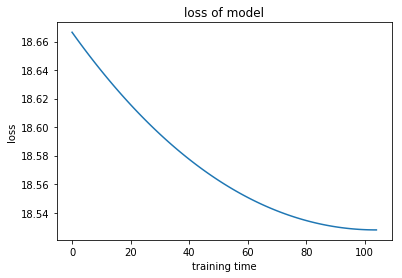

In [11]:
x,theta=collab(matrix_r,dimension,learning_rate,matrix_p)

In [12]:
theta

array([[0.50510708, 0.46478111, 0.44136113, 0.9368873 , 0.18892856,
        0.32865058],
       [0.71370031, 0.24097685, 1.61956261, 0.25585212, 2.34858547,
        0.7092498 ],
       [0.55571922, 0.14477516, 0.68163485, 0.11800405, 1.85875629,
        2.88913122]])

In [15]:
with open("vector.txt",'w') as f:
    f.truncate()
    for i in range(product_num):
        write_in=''
        vec=theta[:,i]
        write_in+=all_product[i]
        write_in+=" "
        for j in vec:
            write_in+=str(j)
            write_in+=" "
        f.write(write_in+"\n")